<a href="https://colab.research.google.com/github/SadoukHamzaTarik/Calibration_test/blob/main/ArBert_AuSTR_downsampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#installing different libraries
!pip install datasets
!pip install transformers
!pip install evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00


In [3]:
#importing packages
import numpy as np
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from torch.utils.data import DataLoader
from transformers import Trainer
import torch
import evaluate
import random
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [4]:
#model specification
checkpoint = "UBC-NLP/ARBERT"
checkpoint_directory = "ARBERT"
n_classes = 3

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/ARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def downsample_dataset(dataset, label_column):
    """
    Downsample the dataset to mitigate class imbalance.

    Parameters:
    dataset (Dataset or pandas DataFrame): The dataset containing all columns, including the label.
    label_column (str): The name of the column containing the class labels.

    Returns:
    downsampled_dataset (Dataset): The downsampled dataset in Hugging Face `Dataset` format.
    """

    # Convert the dataset into a pandas DataFrame if it's not already
    if isinstance(dataset, Dataset):
        df = pd.DataFrame(dataset)
    else:
        df = dataset

    # Check the distribution of classes
    class_counts = Counter(df[label_column])
    print("Original class distribution:", class_counts)

    # Find the minimum class size (minority class)
    min_class_size = min(class_counts.values())
    print(f"Minority class size: {min_class_size}")

    # Downsample each class to match the minority class size
    df_downsampled = df.groupby(label_column).apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)

    # Check the new class distribution
    new_class_counts = Counter(df_downsampled[label_column])
    print("New class distribution after downsampling:", new_class_counts)

    # Convert the downsampled DataFrame back to a Hugging Face Dataset
    downsampled_dataset = Dataset.from_pandas(df_downsampled)

    return downsampled_dataset


In [6]:
#Dataset specification
raw_datasets = load_dataset("bigIR/AuSTR")
dataset_directory = "AuSTR"
raw_datasets

README.md:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

AuSTR_train.tsv:   0%|          | 0.00/321k [00:00<?, ?B/s]

AuSTR_dev.tsv:   0%|          | 0.00/112k [00:00<?, ?B/s]

AuSTR_test.tsv:   0%|          | 0.00/98.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/488 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/166 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/157 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['rumor_tweet_id', 'authority_tweet_id', 'rumor_tweet_text', 'authority_tweet_text', 'stance', 'rumor_label'],
        num_rows: 488
    })
    validation: Dataset({
        features: ['rumor_tweet_id', 'authority_tweet_id', 'rumor_tweet_text', 'authority_tweet_text', 'stance', 'rumor_label'],
        num_rows: 166
    })
    test: Dataset({
        features: ['rumor_tweet_id', 'authority_tweet_id', 'rumor_tweet_text', 'authority_tweet_text', 'stance', 'rumor_label'],
        num_rows: 157
    })
})

In [7]:
# To ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure that all operations on CUDA (if any) are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(24)  # You can use any fixed seed value

In [8]:
# Perform downsampling
downsampled_train_dataset = downsample_dataset(raw_datasets["train"], "stance")

# Replace the original dataset with the downsampled one
raw_datasets["train"] = downsampled_train_dataset

# Check the updated dataset
print(raw_datasets["train"])

Original class distribution: Counter({2: 284, 0: 118, 1: 86})
Minority class size: 86
New class distribution after downsampling: Counter({0: 86, 1: 86, 2: 86})
Dataset({
    features: ['rumor_tweet_id', 'authority_tweet_id', 'rumor_tweet_text', 'authority_tweet_text', 'stance', 'rumor_label'],
    num_rows: 258
})


<ipython-input-5-b64ec53279dc>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_downsampled = df.groupby(label_column).apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)


In [9]:
def tokenize_function(example):
    return tokenizer(
        example["rumor_tweet_text"],
        example["authority_tweet_text"],
        truncation=True,
        padding="max_length",
        max_length=512)
#Dataset tokenization
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["rumor_tweet_text","authority_tweet_text","rumor_label","rumor_tweet_id","authority_tweet_id"])
tokenized_datasets = tokenized_datasets.rename_column("stance","labels")
tokenized_datasets = tokenized_datasets.with_format("torch")
tokenized_datasets

Map:   0%|          | 0/258 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 258
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 166
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 157
    })
})

In [10]:
# Load the F1 metric
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Get the predicted labels by finding the index of the max logit
    predictions = np.argmax(logits, axis=-1)

    # Compute F1 scores for each class (average=None returns a list with F1 scores per class)
    f1_per_class = metric.compute(predictions=predictions, references=labels, average=None)

    # Compute macro-F1 score (mean of F1 for all classes)
    macro_f1 = metric.compute(predictions=predictions, references=labels, average="macro")

    # Compute micro-F1 score (global F1 score)
    micro_f1 = metric.compute(predictions=predictions, references=labels, average="micro")

    return {
        "f1_class_0": f1_per_class["f1"][0],  # F1 for class 0
        "f1_class_1": f1_per_class["f1"][1],  # F1 for class 1
        "f1_class_2": f1_per_class["f1"][2],  # F1 for class 2
        "macro_f1": macro_f1["f1"],           # Overall macro F1
        "micro_f1": micro_f1["f1"],           # Overall micro F1
    }

In [11]:
import os
from datetime import datetime

# Get the current date and time in the desired format
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create the folder name by combining the date, time, and custom string
experiment_name = f"{checkpoint_directory}_{dataset_directory}_{current_time}"

# Create the folder
os.makedirs(experiment_name)


# Define the name of the subdirectory inside the main folder
results_directory = "results"
logs_directory = "logs"

# Create the subdirectory inside the main folder
results_path = os.path.join(experiment_name, results_directory)
os.makedirs(results_path)

logs_path = os.path.join(experiment_name, logs_directory)
os.makedirs(logs_path)


# Get the full path (access link) to the subdirectory
experiment_full_path  = os.path.abspath(experiment_name)
results_full_path = os.path.abspath(results_path)
logs_full_path = os.path.abspath(logs_path)

print(f"Results directory: {results_full_path}")
print(f"Logs directory: {logs_full_path}")
print(f"experiment directory: {experiment_full_path}")

Results directory: /content/ARBERT_AuSTR_2024-10-17_20-34-47/results
Logs directory: /content/ARBERT_AuSTR_2024-10-17_20-34-47/logs
experiment directory: /content/ARBERT_AuSTR_2024-10-17_20-34-47


In [12]:
# trainning hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,                   # Fewer epochs to avoid overfitting
    per_device_train_batch_size=8,        # Smaller batch size
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",           # Regular evaluation
    eval_steps=25,                         # Evaluate every 25 steps
    save_strategy="steps",
    save_steps=250,
    save_total_limit=2,
    load_best_model_at_end=True,           # Early stopping
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=1e-5,                    # Lower learning rate
    weight_decay=0.01,                     # Apply weight decay
    max_grad_norm=1.0,                     # Gradient clipping
    logging_dir="./logs",
    logging_steps=25,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            shuffle=False,  # Disable shuffling here
            collate_fn=self.data_collator,
        )

In [14]:
# Ensure all model parameters are contiguous in memory to prevent potential issues during training.
# Some operations in PyTorch require contiguous tensors for better performance or compatibility,
# and this loop enforces that all model parameters are stored contiguously.
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()

In [15]:
initial_model_state = model.state_dict()  # Save initial weights
model_2 = model

In [17]:
for epochs in [8]:
    training_args.num_train_epochs=epochs
    training_args.output_dir=f"{results_full_path}/epoch_{epochs}"
    training_args.logging_dir=f"{logs_full_path}/epoch_{epochs}"
    model.load_state_dict(initial_model_state)  # Reset model weights
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
    )
    trainer.train()

Step,Training Loss,Validation Loss,F1 Class 0,F1 Class 1,F1 Class 2,Macro F1,Micro F1
25,1.541100,1.495393,0.145455,0.336957,0.000000,0.160804,0.210843
50,1.452500,1.333848,0.388350,0.000000,0.000000,0.129450,0.240964
75,1.366700,1.005687,0.000000,0.000000,0.718147,0.239382,0.560241
100,1.317000,1.134156,0.000000,0.331658,0.000000,0.110553,0.198795
125,1.367300,1.212482,0.000000,0.331658,0.000000,0.110553,0.198795
150,1.255600,1.081572,0.000000,0.000000,0.718147,0.239382,0.560241
175,1.170100,1.056318,0.000000,0.000000,0.718147,0.239382,0.560241
200,1.115800,1.068465,0.000000,0.000000,0.718147,0.239382,0.560241
225,1.146100,1.082037,0.000000,0.000000,0.720930,0.240310,0.560241
250,1.131700,1.071409,0.000000,0.000000,0.720930,0.240310,0.560241


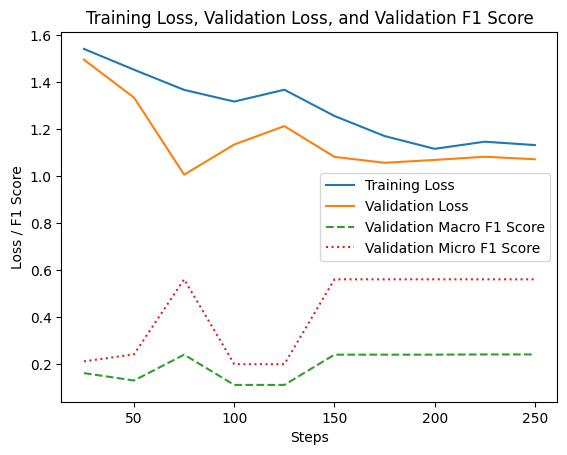

In [18]:
import matplotlib.pyplot as plt

# Extract training loss, validation loss, and F1 score
training_loss = []
validation_loss = []
validation_macro_f1 = []
validation_micro_f1 = []
eval_steps = []
train_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        training_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log:
        validation_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
    if "eval_macro_f1" in log:
        validation_macro_f1.append(log["eval_macro_f1"])
    if "eval_micro_f1" in log:
        validation_micro_f1.append(log["eval_micro_f1"])

# Plot the training and validation loss
plt.plot(train_steps, training_loss, label="Training Loss")
plt.plot(eval_steps, validation_loss, label="Validation Loss")
plt.plot(eval_steps, validation_macro_f1, label="Validation Macro F1 Score", linestyle="--")
plt.plot(eval_steps, validation_micro_f1, label="Validation Micro F1 Score", linestyle="dotted")

# Set labels and title
plt.xlabel("Steps")
plt.ylabel("Loss / F1 Score")
plt.title("Training Loss, Validation Loss, and Validation F1 Score")
plt.legend()
plt.show()


In [18]:
#use to save files
#from google.colab import drive
#drive.mount('/content/drive')
#!cp -r {experiment_full_path} /content/drive/MyDrive

ValueError: mount failed

In [19]:
predictions = trainer.predict(tokenized_datasets["test"])

# Extract logits and true labels
logits = predictions.predictions #(shape: [n_samples, n_classes])
true_labels = predictions.label_ids #(shape: [n_samples])
probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()  # Shape: (n_samples, n_classes)

# Compute the F1 score using your compute_metrics function
f1_score = compute_metrics((logits, true_labels))

# Print the F1 score
f1_score

{'f1_class_0': 0.0,
 'f1_class_1': 0.0,
 'f1_class_2': 0.7235772357723578,
 'macro_f1': 0.24119241192411925,
 'micro_f1': 0.5668789808917197}

In [20]:
true_labels

array([2, 1, 2, 2, 2, 0, 1, 1, 2, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 0, 2, 1, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 0, 2, 2,
       0, 2, 0, 2, 1, 1, 2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0,
       2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 0,
       2, 1, 2])

In [21]:
probabilities

array([[0.30034173, 0.3343207 , 0.36533764],
       [0.30082002, 0.33388713, 0.36529276],
       [0.30059764, 0.3343403 , 0.36506203],
       [0.30014923, 0.33461204, 0.36523876],
       [0.30011675, 0.33464205, 0.36524123],
       [0.3005288 , 0.33438993, 0.36508125],
       [0.3000848 , 0.33466437, 0.36525077],
       [0.30049855, 0.33429864, 0.36520278],
       [0.30014622, 0.334629  , 0.36522475],
       [0.30289412, 0.3325744 , 0.36453146],
       [0.30096307, 0.33395508, 0.36508176],
       [0.30007696, 0.3347422 , 0.36518085],
       [0.30012748, 0.33467385, 0.3651987 ],
       [0.30034006, 0.3344998 , 0.3651601 ],
       [0.30142948, 0.33344433, 0.36512616],
       [0.3013516 , 0.33370852, 0.36493987],
       [0.3006604 , 0.3341828 , 0.36515674],
       [0.30555034, 0.33126685, 0.36318275],
       [0.30056876, 0.33421132, 0.36521992],
       [0.30030227, 0.33449265, 0.3652051 ],
       [0.30042526, 0.33427334, 0.36530137],
       [0.3003877 , 0.33453128, 0.36508107],
       [0.

For a three-label classification problem, you can calculate the reliability diagram and Expected Calibration Error (ECE) for each class by treating the problem as multiple binary classification tasks (one-vs-rest for each class). This is typically done by transforming the problem into three binary sub-problems, one for each class.



In [22]:
def calculate_ece(y_true, y_prob, num_bins, strategy):
    """Compute Expected Calibration Error (ECE)"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = strategy)
    ece = np.sum(np.abs(prob_pred - prob_true) * len(y_true) / num_bins)
    return ece

def plot_reliability_diagram(y_true, y_prob, class_idx, num_bins, strategy):
    """Plot reliability diagram for a specific class"""
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = strategy)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {class_idx}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Reliability Diagram for Class {class_idx}')
    plt.legend()
    plt.show()

Calculating ECE for bins=2


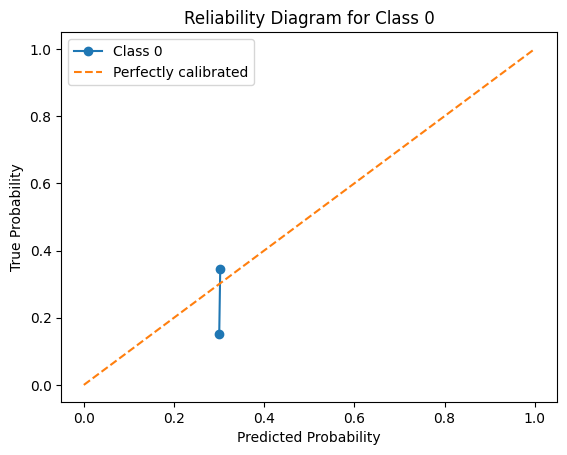

Expected Calibration Error (ECE) for Class 0 with bins=2: 15.075544588700664


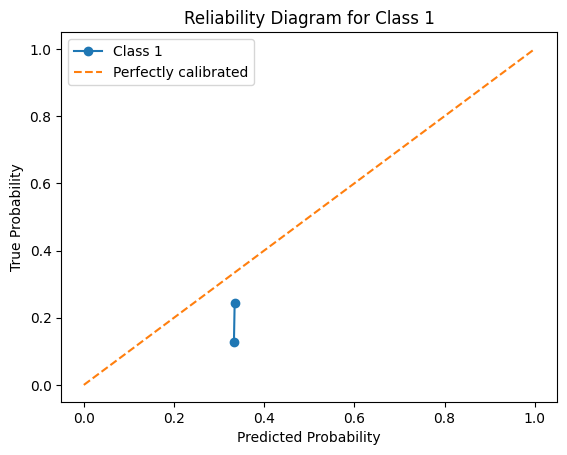

Expected Calibration Error (ECE) for Class 1 with bins=2: 23.332621155660362


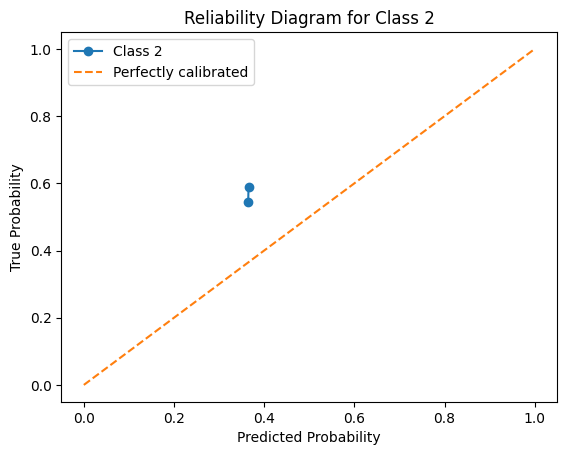

Expected Calibration Error (ECE) for Class 2 with bins=2: 31.734231364036376
Calculating ECE for bins=3


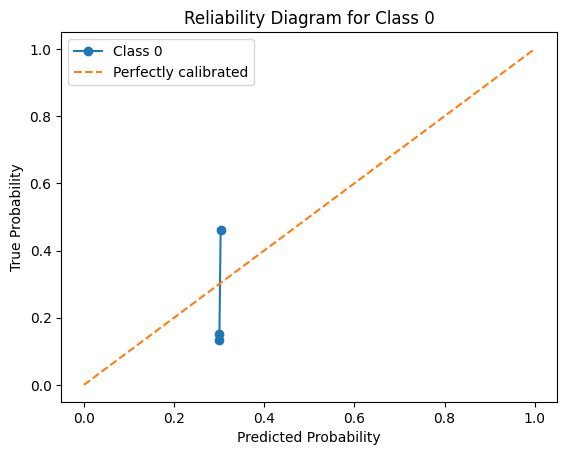

Expected Calibration Error (ECE) for Class 0 with bins=3: 24.76966613942031


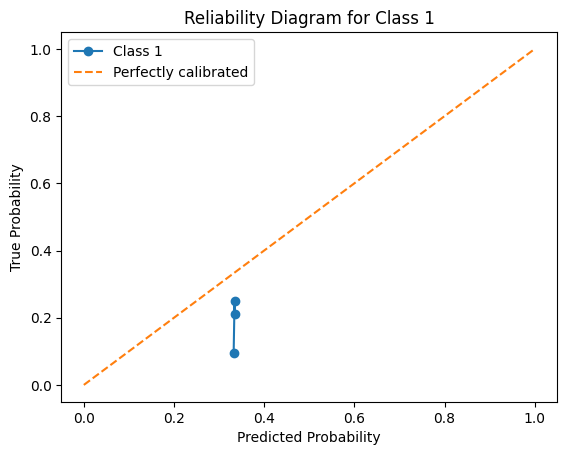

Expected Calibration Error (ECE) for Class 1 with bins=3: 23.30081284419603


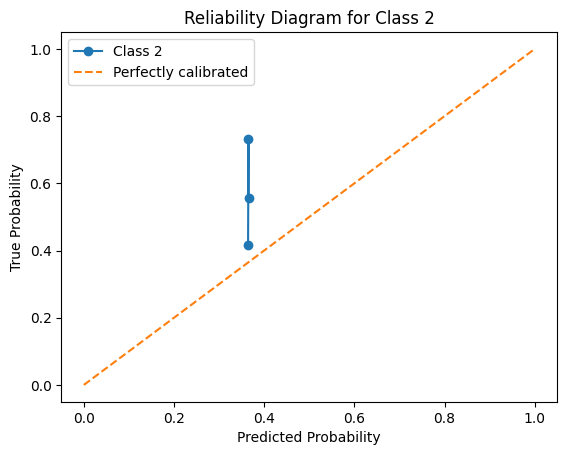

Expected Calibration Error (ECE) for Class 2 with bins=3: 31.86397349531661
Calculating ECE for bins=4


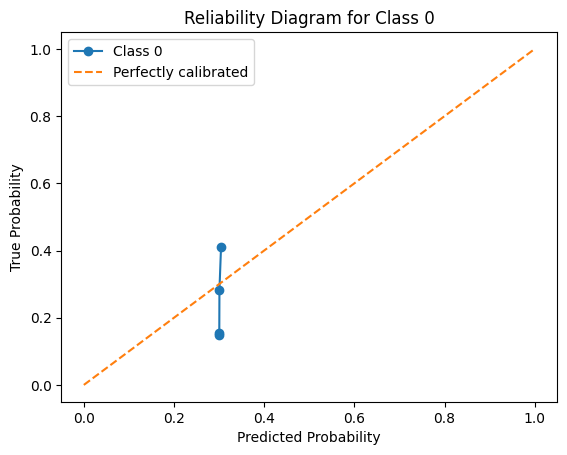

Expected Calibration Error (ECE) for Class 0 with bins=4: 16.541642770749064


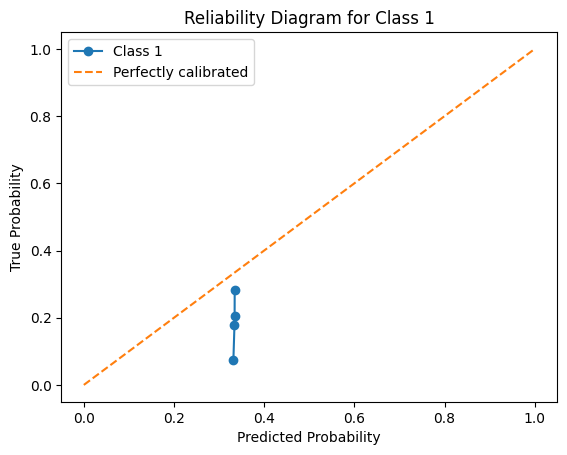

Expected Calibration Error (ECE) for Class 1 with bins=4: 23.28190333729562


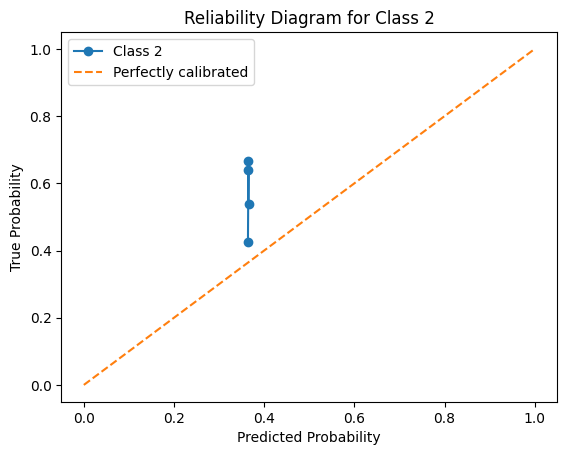

Expected Calibration Error (ECE) for Class 2 with bins=4: 31.85373656786023
Calculating ECE for bins=5


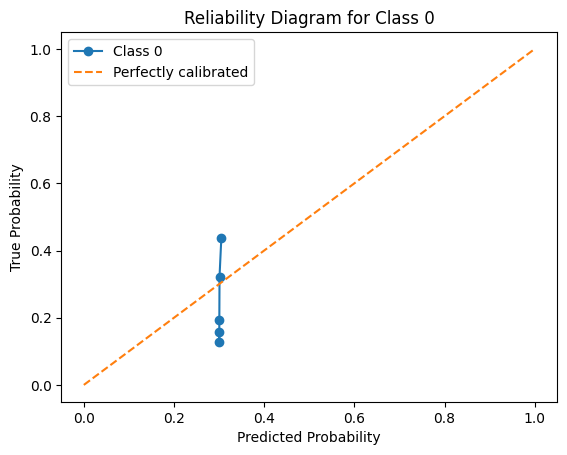

Expected Calibration Error (ECE) for Class 0 with bins=5: 18.099117742460823


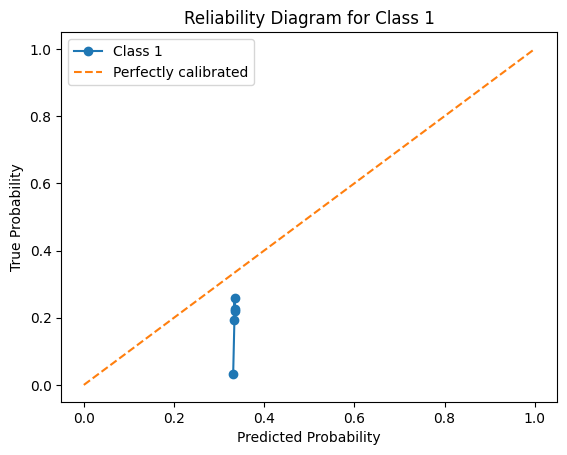

Expected Calibration Error (ECE) for Class 1 with bins=5: 23.270972179963945


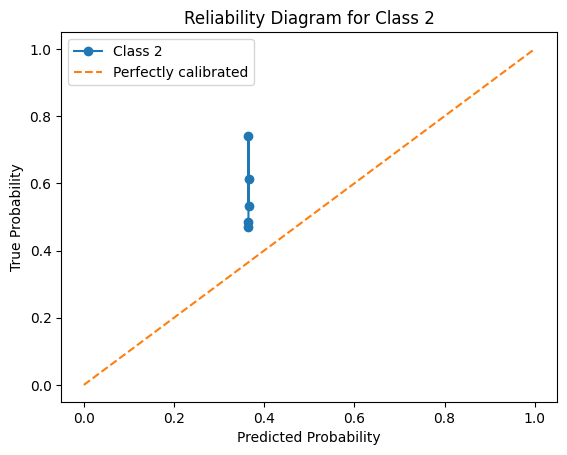

Expected Calibration Error (ECE) for Class 2 with bins=5: 31.846585792639566
Calculating ECE for bins=6


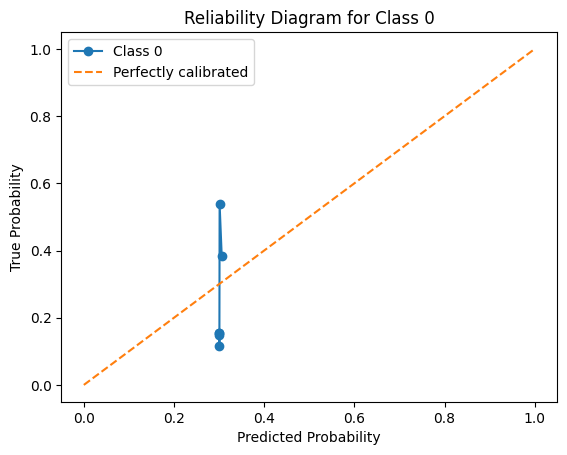

Expected Calibration Error (ECE) for Class 0 with bins=6: 24.766928160158034


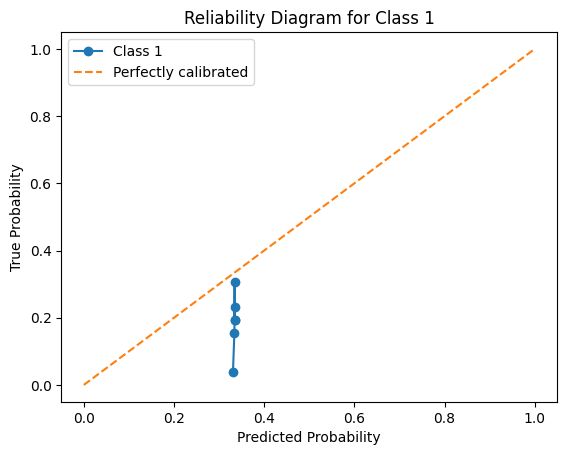

Expected Calibration Error (ECE) for Class 1 with bins=6: 23.24468168950262


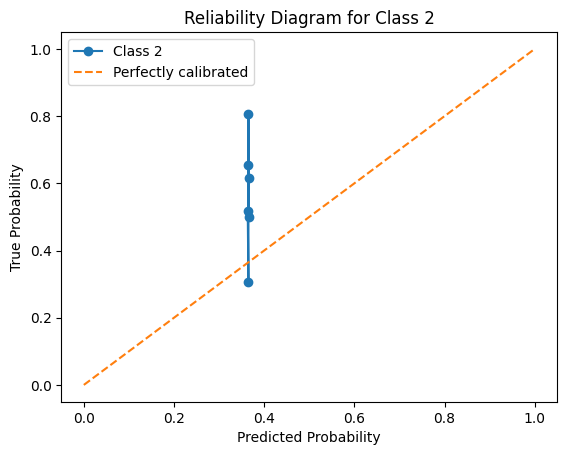

Expected Calibration Error (ECE) for Class 2 with bins=6: 34.75936887862563
Calculating ECE for bins=7


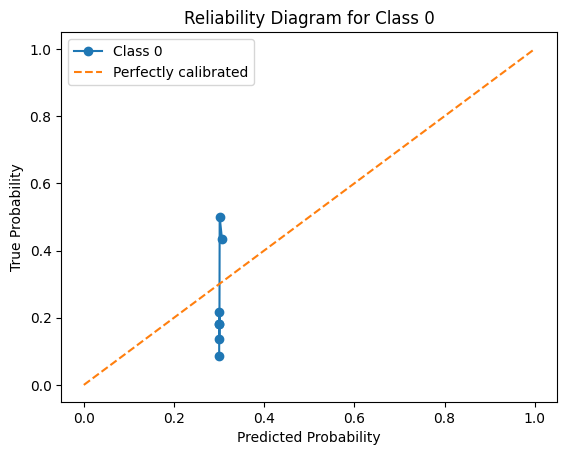

Expected Calibration Error (ECE) for Class 0 with bins=7: 22.988429936941635


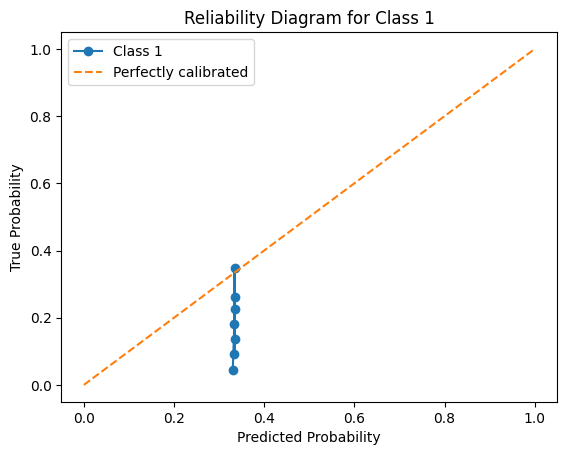

Expected Calibration Error (ECE) for Class 1 with bins=7: 24.098937814734462


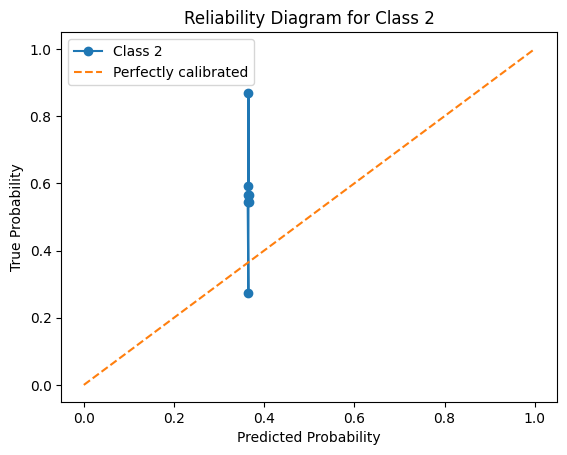

Expected Calibration Error (ECE) for Class 2 with bins=7: 35.543700907246865
Calculating ECE for bins=8


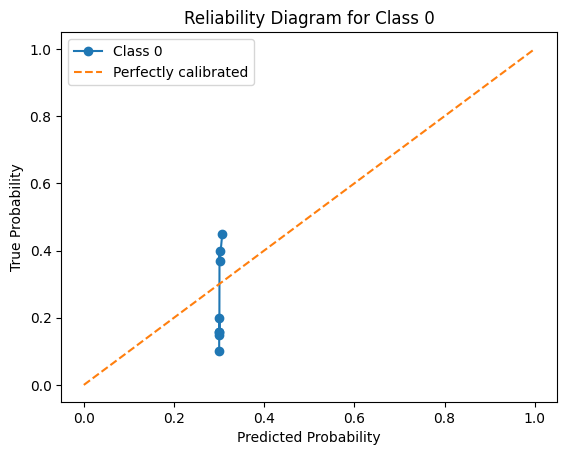

Expected Calibration Error (ECE) for Class 0 with bins=8: 20.51082418510004


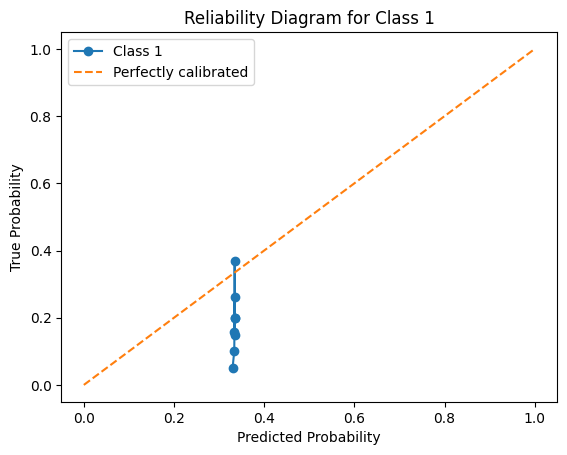

Expected Calibration Error (ECE) for Class 1 with bins=8: 24.491187227399728


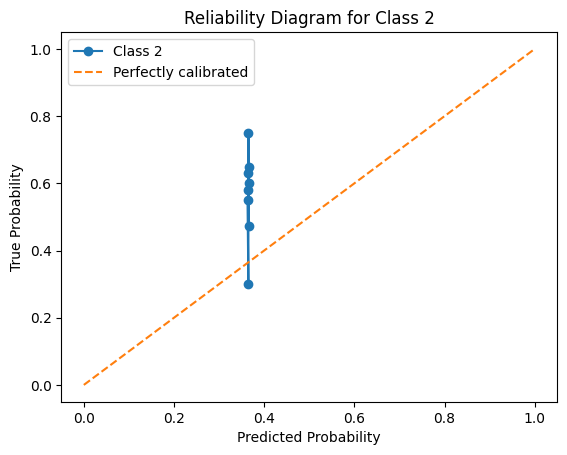

Expected Calibration Error (ECE) for Class 2 with bins=8: 34.243658307733895
Calculating ECE for bins=9


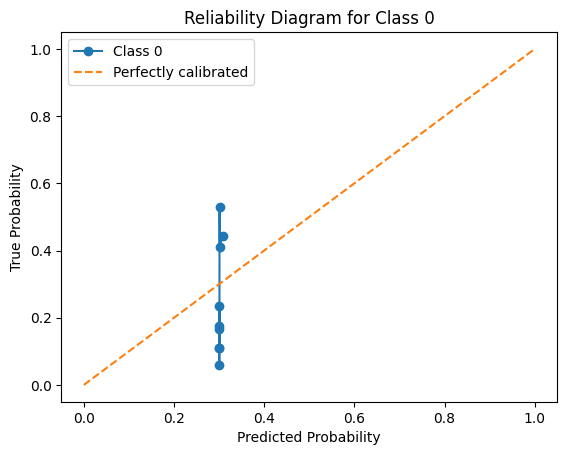

Expected Calibration Error (ECE) for Class 0 with bins=9: 24.742422490413844


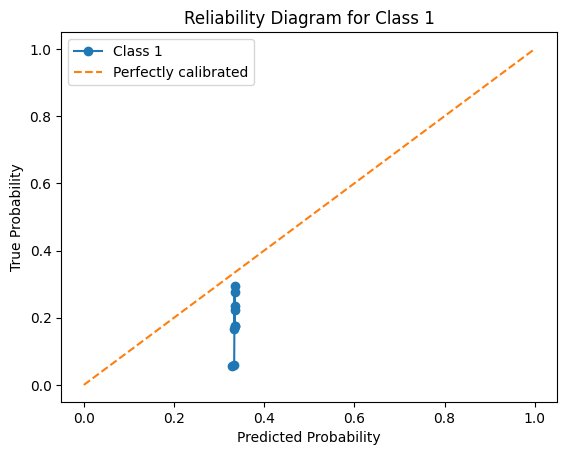

Expected Calibration Error (ECE) for Class 1 with bins=9: 23.375659572846573


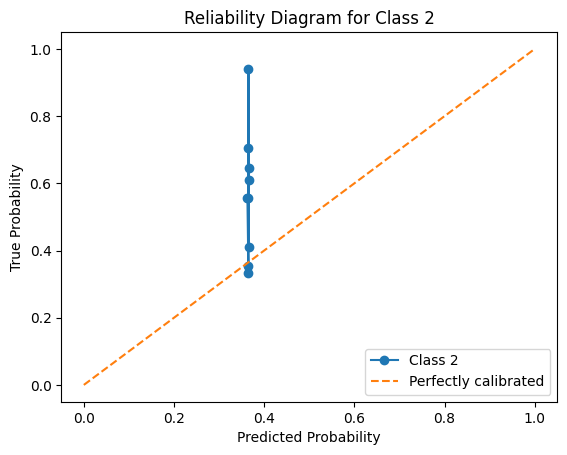

Expected Calibration Error (ECE) for Class 2 with bins=9: 33.45201306952977
Calculating ECE for bins=10


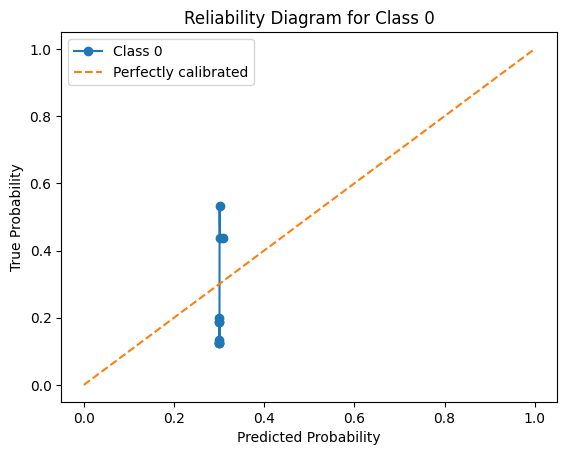

Expected Calibration Error (ECE) for Class 0 with bins=10: 23.814694685911142


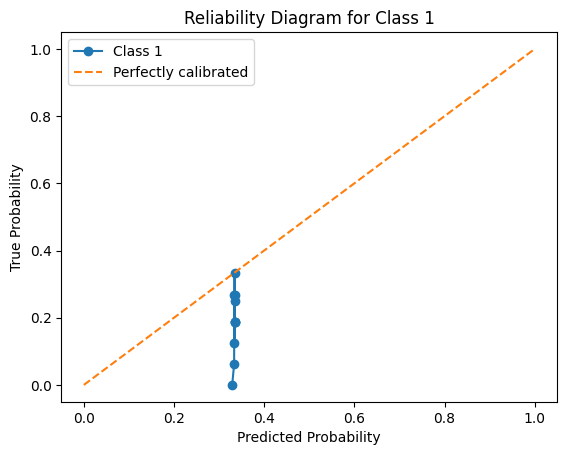

Expected Calibration Error (ECE) for Class 1 with bins=10: 23.085243100374935


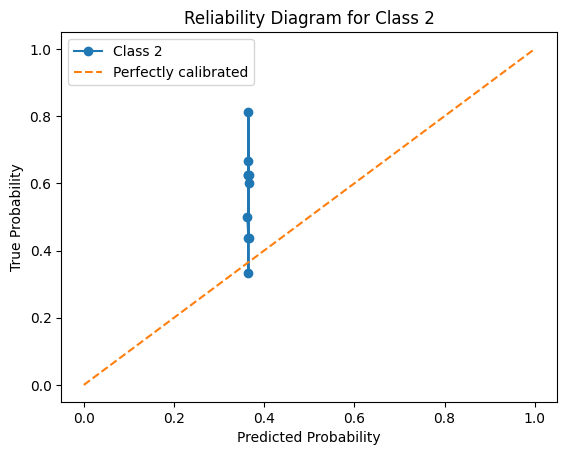

Expected Calibration Error (ECE) for Class 2 with bins=10: 32.60761556502431
ECE results for each class and each value of bins:
Class 0, Bins 2: ECE = 15.075544588700664
Class 0, Bins 3: ECE = 24.76966613942031
Class 0, Bins 4: ECE = 16.541642770749064
Class 0, Bins 5: ECE = 18.099117742460823
Class 0, Bins 6: ECE = 24.766928160158034
Class 0, Bins 7: ECE = 22.988429936941635
Class 0, Bins 8: ECE = 20.51082418510004
Class 0, Bins 9: ECE = 24.742422490413844
Class 0, Bins 10: ECE = 23.814694685911142
Class 1, Bins 2: ECE = 23.332621155660362
Class 1, Bins 3: ECE = 23.30081284419603
Class 1, Bins 4: ECE = 23.28190333729562
Class 1, Bins 5: ECE = 23.270972179963945
Class 1, Bins 6: ECE = 23.24468168950262
Class 1, Bins 7: ECE = 24.098937814734462
Class 1, Bins 8: ECE = 24.491187227399728
Class 1, Bins 9: ECE = 23.375659572846573
Class 1, Bins 10: ECE = 23.085243100374935
Class 2, Bins 2: ECE = 31.734231364036376
Class 2, Bins 3: ECE = 31.86397349531661
Class 2, Bins 4: ECE = 31.8537365678

In [23]:
# Define the bining strategy  strategy{‘uniform’, ‘quantile’}
strg= "quantile"

# Initialize a dictionary to save ECE for each class and each value of bins
ece_results = {class_idx: {} for class_idx in range(n_classes)}

# Loop over the values of bins from 2 to 10
for bins in range(2, 11):
    print(f"Calculating ECE for bins={bins}")

    # Loop over each class (0, 1, 2)
    for class_idx in range(n_classes):
        # Convert true labels to binary (1 if the true label is the current class, 0 otherwise)
        y_true_binary = (true_labels == class_idx).astype(int)

        # Extract probabilities for the current class
        y_prob = probabilities[:, class_idx]

        # Plot reliability diagram for the current class
        plot_reliability_diagram(y_true_binary, y_prob, class_idx, num_bins=bins, strategy=strg)

        # Calculate the ECE for the current class and bin count
        ece = calculate_ece(y_true_binary, y_prob, num_bins=bins, strategy=strg)
        print(f"Expected Calibration Error (ECE) for Class {class_idx} with bins={bins}: {ece}")

        # Save the ECE in the dictionary
        ece_results[class_idx][bins] = ece

# Display or access the saved results in ece_results
print("ECE results for each class and each value of bins:")
for class_idx, ece_per_bin in ece_results.items():
    for bin_count, ece_value in ece_per_bin.items():
        print(f"Class {class_idx}, Bins {bin_count}: ECE = {ece_value}")

